In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import morphine

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


## Zernike basis?

In [2]:
%%time
RADIUS = 1.0 # meters
WAVELENGTH = 1.0e-6 # meters
PIXSCALE = 0.0525 # arcsec / pix
FOV = 5 # arcsec
NWAVES = 1.0
NPIX = 128
D = RADIUS*2
NZ = 300


zernikes = morphine.zernike.zernike_basis(NZ,npix=NPIX,outside=0.0)



CPU times: user 9.8 s, sys: 1.74 s, total: 11.5 s
Wall time: 8.96 s


In [3]:
coefficients_sequence = 5e-9*onp.random.randn(NZ)

# Classical Lyot FPM, spot radius ~ 4 lam/D
anoroc = morphine.OpticalSystem(npix=NPIX)
anoroc.add_pupil( morphine.CircularAperture(radius=RADIUS))
thinlens = morphine.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence,cached_zernikes=zernikes)
anoroc.add_pupil(thinlens)
anoroc.add_image( morphine.CircularOcculter(radius=0.4*RADIUS)) 
anoroc.add_pupil( morphine.CircularAperture(radius=0.9*D/2))
anoroc.add_detector( pixelscale=PIXSCALE, fov_arcsec=FOV )

psf,intermediate = anoroc.propagate_mono(WAVELENGTH)

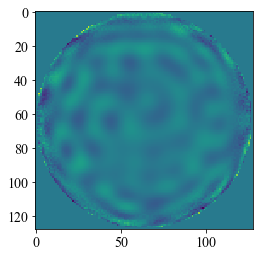

In [4]:
combined_zernikes = np.tensordot(coefficients_sequence,anoroc.planes[1].cached_zernikes,axes=(0,0))

plt.imshow(combined_zernikes)

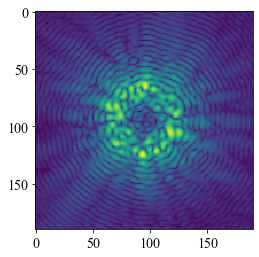

In [5]:
plt.imshow(psf.intensity**0.25)

In [6]:
osys = morphine.OpticalSystem(npix=NPIX)
circular_aperture = morphine.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)
thinlens = morphine.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence,cached_zernikes=zernikes)
osys.add_pupil(thinlens)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)
wf = osys.input_wavefront(WAVELENGTH)


psf_with_zernikewfe = osys.calc_psf(wavelength=WAVELENGTH, display_intermediates=True)


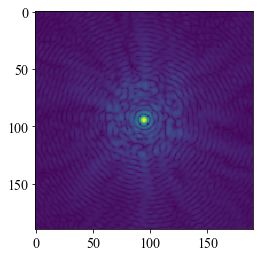

In [7]:
plt.imshow(psf_with_zernikewfe.intensity**0.25)

### Can we differentiate with respect to a Zernike basis?

In [8]:
def psf_from_zernike(coefficients):
    anoroc = morphine.OpticalSystem(npix=NPIX)
    anoroc.add_pupil( morphine.CircularAperture(radius=RADIUS))
    thinlens = morphine.ZernikeWFE(radius=RADIUS, coefficients=coefficients,cached_zernikes=zernikes)
    anoroc.add_pupil(thinlens)
    anoroc.add_image( morphine.CircularOcculter(radius=0.4*RADIUS)) 
    anoroc.add_pupil( morphine.CircularAperture(radius=0.9*D/2))
    anoroc.add_detector( pixelscale=PIXSCALE, fov_arcsec=FOV )
    psf,intermediate = anoroc.propagate_mono(WAVELENGTH)
    return psf

def unobs_psf_zernike(coefficients):
    osys = morphine.OpticalSystem(npix=NPIX)
    circular_aperture = morphine.CircularAperture(radius=RADIUS)
    osys.add_pupil(circular_aperture)
    thinlens = morphine.ZernikeWFE(radius=RADIUS, coefficients=coefficients,cached_zernikes=zernikes)
    osys.add_pupil(thinlens)
    osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)
    psf, intermediates = osys.propagate_mono(WAVELENGTH)
    return psf

arcsec2rad = np.pi/180./3600.
from morphine.matrixDFT import minimal_dft

def get_speckles(coefficients):
    psf = psf_from_zernike(coefficients)
    return psf.amplitude

def calc_uv(wavefront,osys,npix=128):
    nlamd = arcsec2rad*wavefront.pixelscale * wavefront.shape[0] / WAVELENGTH*2*osys.planes[0].pupil_diam
    pupil = wavefront.amplitude**2.
    return minimal_dft(pupil, nlamd, npix)

def uv_from_zernike(coefficients):
    return calc_uv(psf_from_zernike(coefficients),anoroc,npix=NPIX+1)

def uv_unobs_zernike(coefficients):
    return calc_uv(unobs_psf_zernike(coefficients),anoroc,npix=NPIX+1)

def uv_phase(coefficients):
    return np.angle(uv_from_zernike(coefficients))

zero_phase = np.zeros(NZ)

end = get_speckles(zero_phase)


In [9]:
%%time
uvphase = uv_phase(coefficients_sequence*0.001)

CPU times: user 1.01 s, sys: 154 ms, total: 1.16 s
Wall time: 1.01 s


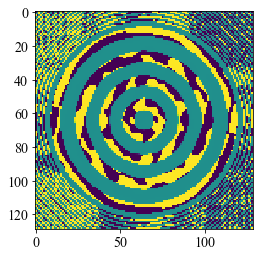

In [10]:
plt.imshow(uvphase)

In [11]:
from jax import jacfwd, jacrev


In [12]:
%load_ext memory_profiler

In [13]:
# phasegrad_fwd = jacfwd(uv_phase)

In [14]:
# %%memit

# fwdgrad = phasegrad_fwd(np.zeros_like(coefficients_sequence))
# print(fwdgrad.sum())


In [15]:
# phasegrad_rev = jacrev(uv_phase)

In [16]:
# %%memit 

# thisgrad = phasegrad_rev(coefficients_sequence)
# print(thisgrad.sum())

## this sucks


In [17]:
# otf = uv_unobs_zernike(np.zeros_like(coefficients_sequence))

In [18]:
# support = (np.abs(otf)>1e-5)
# plt.imshow(support)
# # plt.colorbar()

In [19]:
# fwdgrad_vec = fwdgrad.reshape((NPIX+1)**2, NZ)

In [20]:
# fullgrad = np.dot(fwdgrad_vec,zernikes.reshape(NZ,NPIX*NPIX)).reshape((NPIX+1),NPIX+1,NPIX,NPIX)

In [21]:
# fig, ax = plt.subplots(6,6,figsize=(12, 12))
# columns = 2
# rows = 6
# fs = 16

# pupil_trans = anoroc.planes[0].transmission
# xsec = onp.array([pupil_trans[j,j] for j in range(pupil_trans.shape[0])])
# start, stop = np.min(np.where(xsec==1.)),np.max(np.where(xsec==1.))

# indices_array = np.round(np.linspace(start-2,stop+2,18)).astype('int')

# k = 0
# for j in [0,2,4]:
#     for i in range(rows):
# #         print(indices)
#         indices = indices_array[k]
# #         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
#         phases = onp.copy(fullgrad[:,:,indices,indices])
#         pupil_trans = osys.planes[0].transmission
#         phases[support<1.] = np.nan
#         ax[i,1+j].imshow(phases,cmap=phasemap)

#         ax[i,1+j].set_xticks([])
#         ax[i,1+j].set_yticks([])
#         if i ==0:
#             ax[i,1+j].set_title('u,v',fontsize=fs)
#             ax[i,j].set_title('Pupil',fontsize=fs)

#         ax[i,j].imshow(pupil_trans)
#         ax[i,j].scatter(indices,indices,s=32,c='r')
#         ax[i,j].set_xticks([])
#         ax[i,j].set_yticks([])
#         k+=1

# # plt.savefig('jacobian.png',bbox_inches='tight')
# # plt.savefig('/Users/benjaminpope/code/anoroc/paper/jacobian.pdf',bbox_inches='tight')

### Now try in the speckle domain

In [30]:
%%memit 
# %%timeit

specgrad_fun = jacfwd(get_speckles)
specgrad = specgrad_fun(zero_phase)
print(specgrad.max())


289571.44
peak memory: 3234.36 MiB, increment: 14.54 MiB


In [23]:
speckles = get_speckles(zero_phase)

In [24]:
fullgrad = np.tensordot(specgrad,zernikes,axes=[2,0])

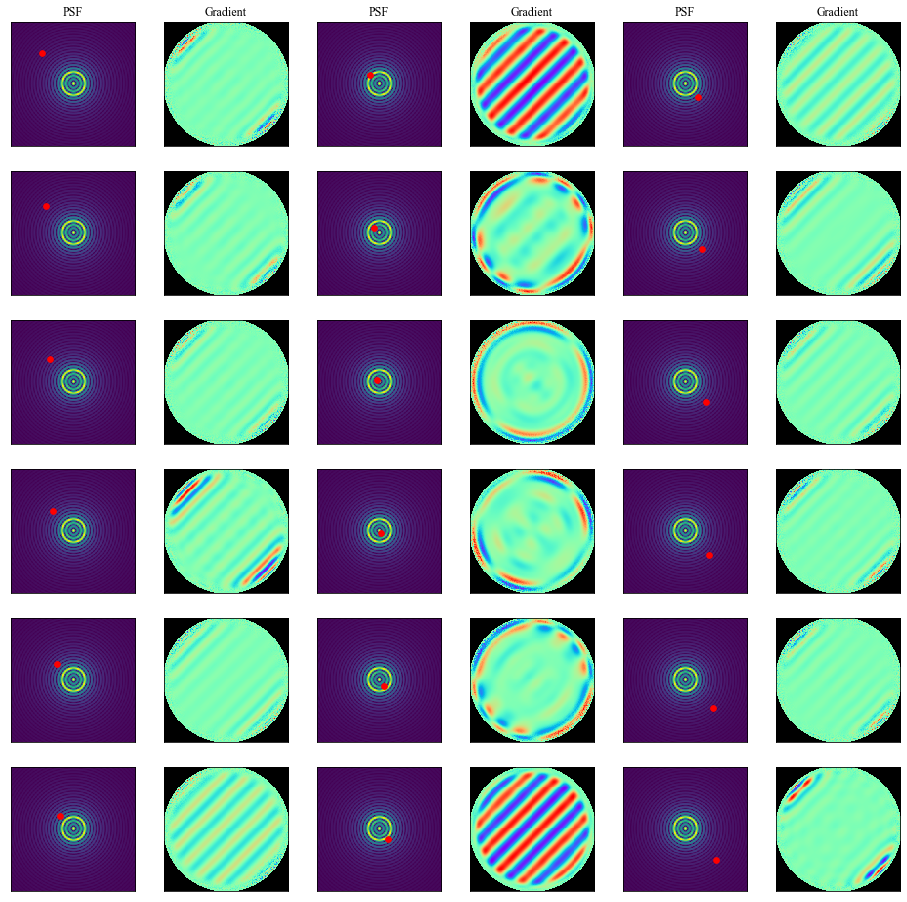

In [25]:
fig, ax = plt.subplots(6,6,figsize=(16, 16))
columns = 2
rows = 6

indices_array = np.round(np.linspace(speckles.shape[0]*0.25,speckles.shape[0]*0.75,18)).astype('int')

k = 0
for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        indices = indices_array[k]
        phases = onp.copy(fullgrad[indices,indices,:,:])
        phases[anoroc.planes[0].transmission==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)
#         ax[i,1+j].set_xlim(32,128-32)
#         ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('PSF')

        ax[i,j].imshow(speckles)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k+=1

plt.savefig('speckle_jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/speckle_jacobian_zernike.pdf',bbox_inches='tight')

In [26]:
NZ

300